<a href="https://colab.research.google.com/github/sasidhar-guthi/Histopathology_Cancer_Detection/blob/main/Histopathelogic_cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing and understanding the data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip '/content/gdrive/MyDrive/histopathologic-cancer-detection.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: train/fa2f1d5e86165f63c57acdf9d23521f2b8070e0c.tif  
  inflating: train/fa2ffa

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
full_train_df = pd.read_csv("/content/train_labels.csv")
full_train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [ ]:
print("Train Size: {}".format(len(os.listdir('/content/test'))))
print("Test Size: {}".format(len(os.listdir('/content/train'))))

Train Size: 57458
Test Size: 220025


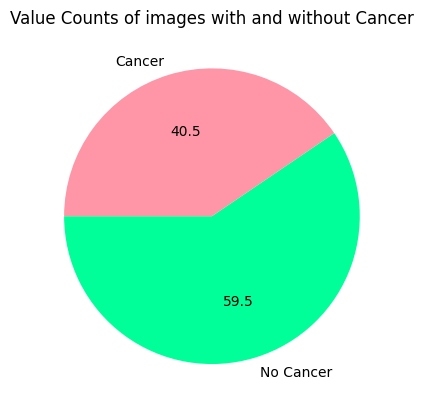

<Figure size 1600x1600 with 0 Axes>

In [ ]:
labels_count = full_train_df.label.value_counts()
plt.title('Value Counts of images with and without Cancer')
%matplotlib inline
plt.pie(labels_count, labels=['No Cancer', 'Cancer'], startangle=180, 
        autopct='%1.1f', colors=['#00ff99','#FF96A7'], shadow=False)
plt.figure(figsize=(16,16))

plt.show()

### Visualizing Images

In [ ]:
from glob import glob 
import numpy as np
import pandas as pd
import keras,cv2,os

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D

In [ ]:
from tqdm import tqdm_notebook,trange
import matplotlib.pyplot as plt

import gc #garbage collection, we need to clean up and save memory
#set paths to training and test data
path = "/content/" #adapt this path, when running locally
train_path = path + 'train/'
test_path = path + 'test/'

In [ ]:
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) # load the filenames

In [ ]:
pd.set_option('display.max_colwidth', None)
df.head()

,path
0,/content/train/5f8815de326e83cd7889df936218e60a47824c6c.tif
1,/content/train/7b1b9729bb91aeca982bbb43e95af6581a7cdfc6.tif
2,/content/train/4d997052c0674483c478f5eb380634b95ee3bd2a.tif
3,/content/train/5a9e55d3b61962fa11d1d47fa207239b8ae655d2.tif
4,/content/train/13a7dc62c89ca01b387fb331be0dafd96bcfd056.tif


In [ ]:
df['id'] = df.path.map(lambda x: x.split('/')[3].split(".")[0]) # keep only the file names in 'id'
labels = pd.read_csv(path+"train_labels.csv") # read the provided labels
df = df.merge(labels, on = "id") # merge labels and filepaths
df.head(10) # print the first 10 entries

,path,id,label
0,/content/train/5f8815de326e83cd7889df936218e60a47824c6c.tif,5f8815de326e83cd7889df936218e60a47824c6c,1
1,/content/train/7b1b9729bb91aeca982bbb43e95af6581a7cdfc6.tif,7b1b9729bb91aeca982bbb43e95af6581a7cdfc6,0
2,/content/train/4d997052c0674483c478f5eb380634b95ee3bd2a.tif,4d997052c0674483c478f5eb380634b95ee3bd2a,0
3,/content/train/5a9e55d3b61962fa11d1d47fa207239b8ae655d2.tif,5a9e55d3b61962fa11d1d47fa207239b8ae655d2,0
4,/content/train/13a7dc62c89ca01b387fb331be0dafd96bcfd056.tif,13a7dc62c89ca01b387fb331be0dafd96bcfd056,0
5,/content/train/3217f8a4420bc920afe4364b3eaea52de929b670.tif,3217f8a4420bc920afe4364b3eaea52de929b670,1
6,/content/train/631a5081d3cbc2ac8c0d87ca8a9b615ff78d77b5.tif,631a5081d3cbc2ac8c0d87ca8a9b615ff78d77b5,0
7,/content/train/3b330edb56f56006834e924010ee5f144d7754e5.tif,3b330edb56f56006834e924010ee5f144d7754e5,0
8,/content/train/e7dd70f9a44e7941573d97e373525eb255e78c9b.tif,e7dd70f9a44e7941573d97e373525eb255e78c9b,0
9,/content/train/040a01d65b23df4d5c0480311c16cc106e5e8fd4.tif,040a01d65b23df4d5c0480311c16cc106e5e8fd4,0


In [ ]:
def load_data(N,df):
    #This functions loads N images using the data df
    # allocating a numpy array for the images (N, 96x96px, 3 channels, values 0 - 255)
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    #converting the labels to a numpy array too
    y = np.squeeze(df['label'].to_numpy())[0:N]
    #reading images one by one, tdqm notebook displays a progress bar
    for i, row in tqdm_notebook(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])
          
    return X,y

df.shape


N=10000
X,y = load_data(N=N,df=df) 

<ipython-input-12-4ce6043cdf75>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, row in tqdm_notebook(df.iterrows(), total=N):


  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0, 0.5, '# of samples')

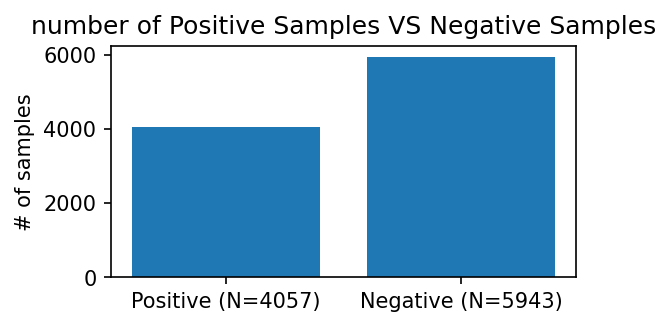

In [ ]:
fig = plt.figure(figsize=(4, 2),dpi=150)
plt.title("number of Positive Samples VS Negative Samples")
plt.bar([1,0], [(y==0).sum(), (y==1).sum()]);
plt.xticks([1,0],["Negative (N={})".format((y==0).sum()),"Positive (N={})".format((y==1).sum())]);
plt.ylabel("# of samples") 

In [ ]:
positive_samples = X[y == 1]
negative_samples = X[y == 0]

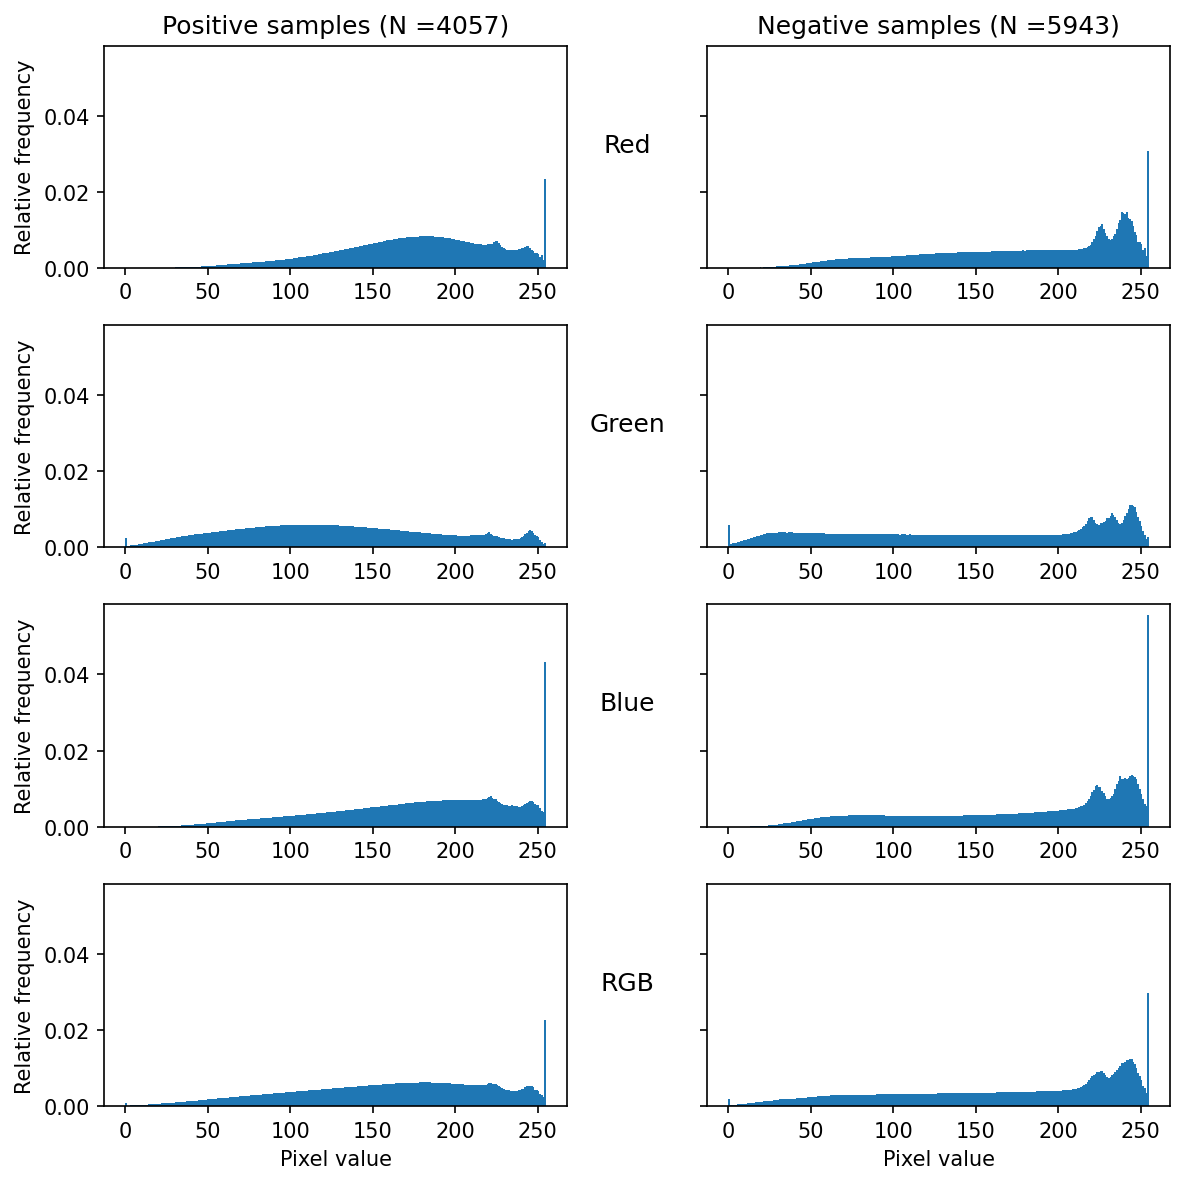

In [ ]:
nr_of_bins = 256
fig,axs = plt.subplots(4,2,sharey=True,figsize=(8,8),dpi=150)

#RGB channels
axs[0,0].hist(positive_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
axs[0,1].hist(negative_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
axs[1,0].hist(positive_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
axs[1,1].hist(negative_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
axs[2,0].hist(positive_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)
axs[2,1].hist(negative_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)

#All channels
axs[3,0].hist(positive_samples.flatten(),bins=nr_of_bins,density=True)
axs[3,1].hist(negative_samples.flatten(),bins=nr_of_bins,density=True)

#Set image labels
axs[0,0].set_title("Positive samples (N =" + str(positive_samples.shape[0]) + ")");
axs[0,1].set_title("Negative samples (N =" + str(negative_samples.shape[0]) + ")");
axs[0,1].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12)
axs[1,1].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12)
axs[2,1].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12)
axs[3,1].set_ylabel("RGB",rotation='horizontal',labelpad=35,fontsize=12)
for i in range(4):
    axs[i,0].set_ylabel("Relative frequency")
axs[3,0].set_xlabel("Pixel value")
axs[3,1].set_xlabel("Pixel value")
fig.tight_layout()

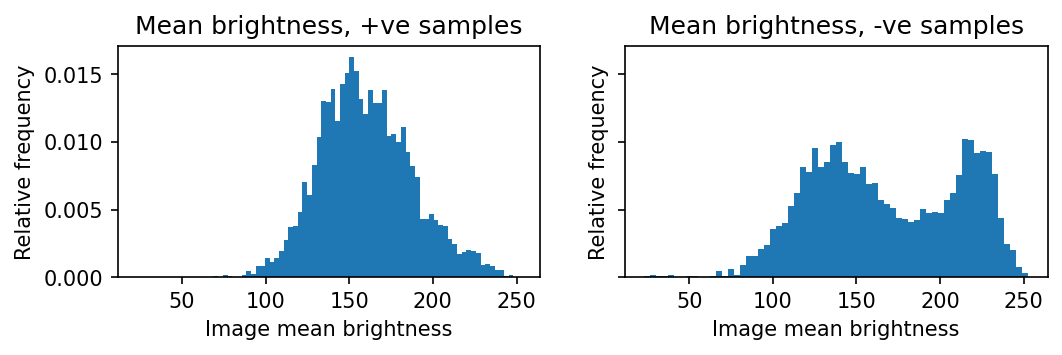

In [ ]:
nr_of_bins = 64 #we use a bit fewer bins to get a smoother image
fig,axs = plt.subplots(1,2,sharey=True, sharex = True, figsize=(8,2),dpi=150)
axs[0].hist(np.mean(positive_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[1].hist(np.mean(negative_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[0].set_title("Mean brightness, +ve samples");
axs[1].set_title("Mean brightness, -ve samples");
axs[0].set_xlabel("Image mean brightness")
axs[1].set_xlabel("Image mean brightness")
axs[0].set_ylabel("Relative frequency")
axs[1].set_ylabel("Relative frequency");

### Sampling

In [ ]:
import sklearn

# Number of samples in each class
SAMPLE_SIZE = 80000

# Data paths
train_path = '/content/train/'
test_path = '/content/test/'

# Using 80000 positive and negative examples
df_negatives = full_train_df[full_train_df['label'] == 0].sample(SAMPLE_SIZE, random_state=42)
df_positives = full_train_df[full_train_df['label'] == 1].sample(SAMPLE_SIZE, random_state=42)

# Concatenate the two dfs and shuffle them up
train_df = sklearn.utils.shuffle(pd.concat([df_positives, df_negatives], axis=0).reset_index(drop=True))

train_df.shape

(160000, 2)

### Data Pre-processing for our PyTorch

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
# custom class for datasets
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = CreateDataset(df_data=train_df, data_dir=train_path, transform=transforms_train)

In [ ]:
# Set Batch Size
batch_size = 128

# Percentage of training set to use as validation
valid_size = 0.1

# training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)

In [ ]:
transforms_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# test data
sample_sub = pd.read_csv("/content/sample_submission.csv")
test_data = CreateDataset(df_data=sample_sub, data_dir=test_path, transform=transforms_test)

# test loader
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

### Defining Model Architecture

In [ ]:
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        # Convolutional and Pooling Layers
        self.conv1=nn.Sequential(
                nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=0),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv2=nn.Sequential(
                nn.Conv2d(in_channels=32,out_channels=64,kernel_size=2,stride=1,padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv3=nn.Sequential(
                nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv4=nn.Sequential(
                nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv5=nn.Sequential(
                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        
        self.dropout2d = nn.Dropout2d()
        
        self.fc=nn.Sequential(
                nn.Linear(512*3*3,1024),
                nn.ReLU(inplace=True),
                nn.Dropout(0.4),
                nn.Linear(1024,512),
                nn.Dropout(0.4),
                nn.Linear(512, 1),
                nn.Sigmoid())
        
    def forward(self,x):
        """Method for Forward Prop"""
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.conv5(x)
        x=x.view(x.shape[0],-1)
        x=self.fc(x)
        return x

In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


### Training and Validation

In [ ]:
# create a complete CNN
model_cnn = CNN()
print(model_cnn)

# Moving model to GPU if available
if train_on_gpu: model_cnn.cuda()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [ ]:
# Trainable Parameters
pytorch_total_params = sum(p.numel() for p in model_cnn.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
6805249


In [ ]:
import torch.optim as optim
from sklearn.metrics import roc_auc_score

In [ ]:
# loss function (categorical cross-entropy loss)
criterion = nn.BCELoss()

# optimizer
optimizer = optim.Adam(model_cnn.parameters(), lr=0.00015)

In [ ]:
# number of epochs to train the model
n_epochs = 10

valid_loss_min = np.Inf

train_losses = []
valid_losses = []
val_auc = []
test_accuracies = []
valid_accuracies = []
auc_epoch = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model_cnn.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        target = target.view(-1, 1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_cnn(data)
        # calculate the batch loss
        loss = criterion(output, target.float())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # Update Train loss and accuracies
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model_cnn.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        # forward pass: compute predicted outputs by passing inputs to the model
        target = target.view(-1, 1)
        output = model_cnn(data)
        # calculate the batch loss
        loss = criterion(output, target.float())
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        #output = output.topk()
        y_actual = target.data.cpu().numpy()
        y_pred = output[:,-1].detach().cpu().numpy()
        val_auc.append(roc_auc_score(y_actual, y_pred))        
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_auc = np.mean(val_auc)
    auc_epoch.append(np.mean(val_auc))
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} | Training Loss: {:.6f} | Validation Loss: {:.6f} | Validation AUC: {:.4f}'.format(
        epoch, train_loss, valid_loss, valid_auc))
    
    ##################
    # Early Stopping #
    ##################
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model_cnn.state_dict(), 'best_model.pt')
        valid_loss_min = valid_loss

Epoch: 1 | Training Loss: 0.367021 | Validation Loss: 0.301931 | Validation AUC: 0.9488
Validation loss decreased (inf --> 0.301931).  Saving model ...
Epoch: 2 | Training Loss: 0.291881 | Validation Loss: 0.251056 | Validation AUC: 0.9558
Validation loss decreased (0.301931 --> 0.251056).  Saving model ...
Epoch: 3 | Training Loss: 0.255295 | Validation Loss: 0.330468 | Validation AUC: 0.9581
Epoch: 4 | Training Loss: 0.231581 | Validation Loss: 0.220063 | Validation AUC: 0.9617
Validation loss decreased (0.251056 --> 0.220063).  Saving model ...
Epoch: 5 | Training Loss: 0.214136 | Validation Loss: 0.237676 | Validation AUC: 0.9638
Epoch: 6 | Training Loss: 0.199165 | Validation Loss: 0.197613 | Validation AUC: 0.9660
Validation loss decreased (0.220063 --> 0.197613).  Saving model ...
Epoch: 7 | Training Loss: 0.192541 | Validation Loss: 0.186449 | Validation AUC: 0.9677
Validation loss decreased (0.197613 --> 0.186449).  Saving model ...
Epoch: 8 | Training Loss: 0.182879 | Validat

In [ ]:
# Best parameters learned from training into our model to make predictions later
model_cnn.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

### Predictions on Test set

In [ ]:
model_cnn.eval()

preds = []
for batch_i, (data, target) in enumerate(test_loader):
    data, target = data.cuda(), target.cuda()
    output = model_cnn(data)

    pr = output.detach().cpu().numpy()
    for i in pr:
        preds.append(i)

# Submission file        
sample_sub['label'] = preds

In [ ]:
sample_sub

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,[0.014099037]
1,95596b92e5066c5c52466c90b69ff089b39f2737,[0.43106502]
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,[0.0071656066]
3,2c35657e312966e9294eac6841726ff3a748febf,[0.0042214287]
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,[0.09635676]
...,...,...
57453,061847314ded6f81e1cd670748bfa2003442c9c7,[0.026547275]
57454,6f3977130212641fd5808210015a609c658dcbff,[0.011219946]
57455,46935f247278539eca74b54d07d666efb528a753,[0.001803836]
57456,a09bcae08a82120183352e0e869181b2911d3dc1,[0.0013010275]


In [ ]:
for i in range(len(sample_sub)):
    sample_sub.label[i] = np.float(sample_sub.label[i])

<ipython-input-34-470857900eec>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_sub.label[i] = np.float(sample_sub.label[i])


In [ ]:
sample_sub.to_csv('submission.csv', index=False)
sample_sub.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.014099
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.431065
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.007166
3,2c35657e312966e9294eac6841726ff3a748febf,0.004221
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.096357


### Visualizing Predictions

In [ ]:
def imshow(img):
    #Helper function to un-normalize and display an image
    img = img / 2 + 0.5
    # convert from Tensor image and display
    plt.imshow(np.transpose(img, (1, 2, 0)))

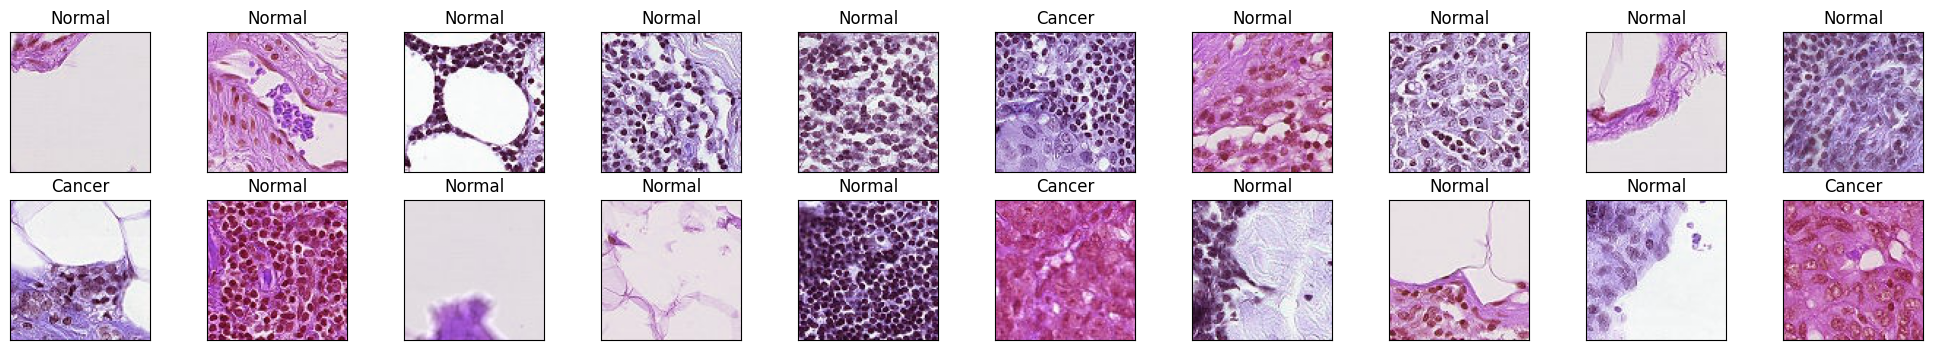

In [ ]:
# obtain one batch of training images
dataiter = iter(test_loader)
images, labels = dataiter.__next__()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    prob = "Cancer" if(sample_sub.label[idx] >= 0.5) else "Normal" 
    ax.set_title('{}'.format(prob))

###Autoencoder

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2, padding=0, output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encode
        x = self.encoder(x)

        # Decode
        x = self.decoder(x)

        return x

In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# create a complete CNN
model = Autoencoder()
print(model)

# Move model to GPU if available
if train_on_gpu: model.cuda()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, trac

In [ ]:
# Trainable Parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
3088387


In [ ]:
import torch.optim as optim
from sklearn.metrics import roc_auc_score
# loss function (categorical cross-entropy loss)
criterion = nn.BCELoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00015)

In [ ]:
# number of epochs to train the model
n_epochs = 10

valid_loss_min = np.Inf

train_losses = []
valid_losses = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, _ in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data = data.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        encoded = model.encoder(data)
        decoded = model.decoder(encoded)
        # calculate the batch loss
        loss = criterion(decoded, data)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # Update Train loss and accuracies
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, _ in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data = data.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        encoded = model.encoder(data)
        decoded = model.decoder(encoded)
        # calculate the batch loss
        loss = criterion(decoded, data)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} | Training Loss: {:.6f} | Validation Loss: {:.6f} | Validation AUC: {:.4f}'.format(
        epoch, train_loss, valid_loss, valid_auc))
    
    ##################
    # Early Stopping #
    ##################
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'best_model.pt')
        valid_loss_min = valid_loss


Epoch: 1 | Training Loss: -0.765445 | Validation Loss: -1.996110 | Validation AUC: 0.9708
Validation loss decreased (inf --> -1.996110).  Saving model ...
Epoch: 2 | Training Loss: -2.892529 | Validation Loss: -3.642060 | Validation AUC: 0.9708
Validation loss decreased (-1.996110 --> -3.642060).  Saving model ...
Epoch: 3 | Training Loss: -4.163228 | Validation Loss: -4.652042 | Validation AUC: 0.9708
Validation loss decreased (-3.642060 --> -4.652042).  Saving model ...
Epoch: 4 | Training Loss: -4.814183 | Validation Loss: -5.094528 | Validation AUC: 0.9708
Validation loss decreased (-4.652042 --> -5.094528).  Saving model ...
Epoch: 5 | Training Loss: -5.231528 | Validation Loss: -5.569705 | Validation AUC: 0.9708
Validation loss decreased (-5.094528 --> -5.569705).  Saving model ...
Epoch: 6 | Training Loss: -5.661767 | Validation Loss: -5.860104 | Validation AUC: 0.9708
Validation loss decreased (-5.569705 --> -5.860104).  Saving model ...
Epoch: 7 | Training Loss: -6.153845 | Va

###Visualizing difference between Normal Images and Reconstructed Images

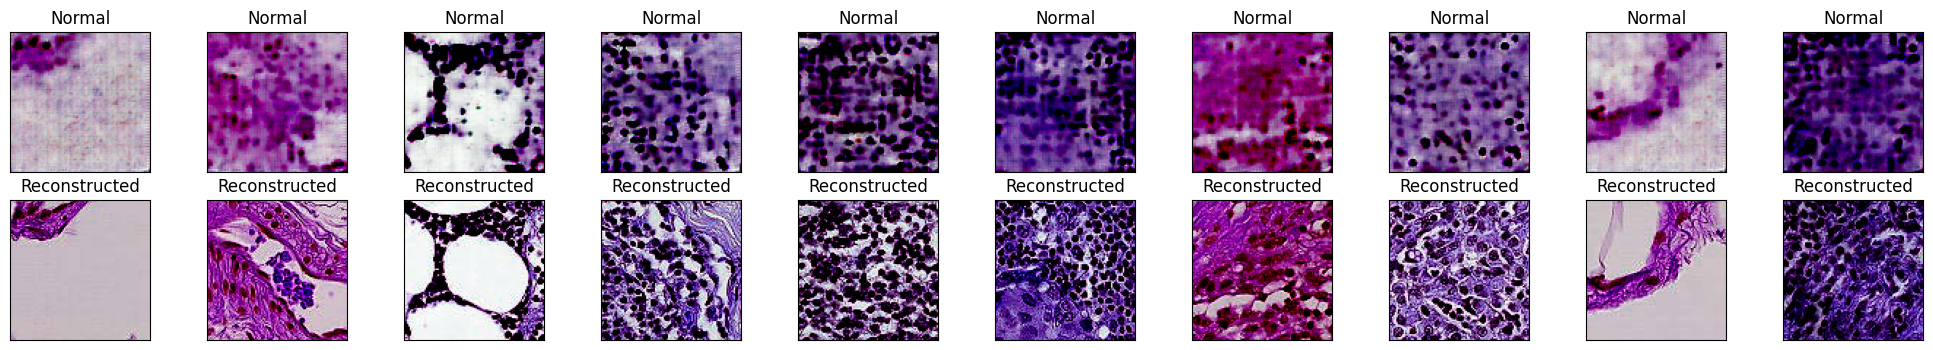

In [ ]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# load the trained model
model.load_state_dict(torch.load('best_model.pt'))
dataiter = iter(test_loader)
images, labels = dataiter.__next__()

# move the input images to the GPU if available
if train_on_gpu:
    images = images.cuda()

# pass the input images through the model and obtain the output
encoded = model.encoder(images)
decoded = model.decoder(encoded)
# convert the images to numpy arrays and transpose the axes to plot them using matplotlib
images = images.cpu().numpy().transpose((0, 2, 3, 1))
decoded = decoded.detach().cpu().numpy().transpose((0, 2, 3, 1))

# plot the original images and their reconstructions
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# Then, loop through the rows and images, and add the labels to the first row
for images, row in zip([decoded, images], axes):
    for img, ax in zip(images, row):
        ax.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        y_pos_str = str(ax).split(',')[1]
        y_pos = float(y_pos_str.split(';')[0].strip())
        if y_pos == 0.53:
          ax.set_title('Normal')
        else:
          ax.set_title('Reconstructed')
            
plt.show()